<a href="https://colab.research.google.com/github/opi-lab/stsiva-workshop/blob/main/notebooks/stsiva_workshop_notebook03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structured Light 3D reconstruction

*STSIVA Workshop - 2021*

**Speakers:**    
Jhacson Meza - [@jhacsonmeza](https://github.com/jhacsonmeza)    
Andrés G. Marrugo, PhD -     [@agmarrugo](https://github.com/agmarrugo)     
Universidad Tecnológica de Bolívar    

In this example, we will estimate the 3D reconstruction of an object based on stereo triangulation. We have a camera-projector setup where we project patterns to establish correspondences between both devices for triangulation.

*The source of this notebook is located at https://github.com/opi-lab/stsiva-workshop/*

*Useful intro about [Colab](https://colab.research.google.com/notebooks/welcome.ipynb)*

*Useful intro about [OpenCV](https://opencv.org/)*

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import glob
import cv2

We need first to download the dataset for this example.

Let's download the images

In [ ]:
!apt install subversion
!svn checkout https://github.com/opi-lab/stsiva-workshop/trunk/data/recons/images

Reading package lists... Done
Building dependency tree       
Reading state information... Done
subversion is already the newest version (1.9.7-4ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Checked out revision 20.


Now we need to download the camera-projector calibration parameters, and the mask of the object to reconstruct.

In [ ]:
!wget https://raw.githubusercontent.com/opi-lab/stsiva-workshop/main/data/recons/cam_proj_param.npz
!wget https://raw.githubusercontent.com/opi-lab/stsiva-workshop/main/data/recons/mask.png

--2021-09-17 18:50:19--  https://raw.githubusercontent.com/opi-lab/stsiva-workshop/main/data/recons/cam_proj_param.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2072 (2.0K) [application/octet-stream]
Saving to: ‘cam_proj_param.npz.4’

cam_proj_param.npz. 100%[===================>]   2.02K  --.-KB/s    in 0s      

2021-09-17 18:50:19 (36.5 MB/s) - ‘cam_proj_param.npz.4’ saved [2072/2072]

--2021-09-17 18:50:19--  https://raw.githubusercontent.com/opi-lab/stsiva-workshop/main/data/recons/mask.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response

We need first the dataset of images for reconstruction. We will store all the image filenames in a list.

In [ ]:
imlist = sorted(glob.glob('images/*'))

Load camera-projector calibration parameters:

In [ ]:
params = np.load('cam_proj_param.npz')

K1 = params['K1']
K2 = params['K2']
dist1 = params['dist1']
dist2 = params['dist2']

R = params['R']
t = params['t']

# Build projection matrices
P1 = K1 @ np.c_[np.eye(3), np.zeros(3)]
P2 = K2 @ np.c_[R, t]

Phase shifting step and fringe period

In [ ]:
N = 18
p = 18

Read image with texture and mask

In [ ]:
im = cv2.imread(imlist[-1], 0)
mask = cv2.imread('mask.png', 0)

This is the object we want to reconstruct with the structured light technique, and the mask to filter out pixels outside the object.

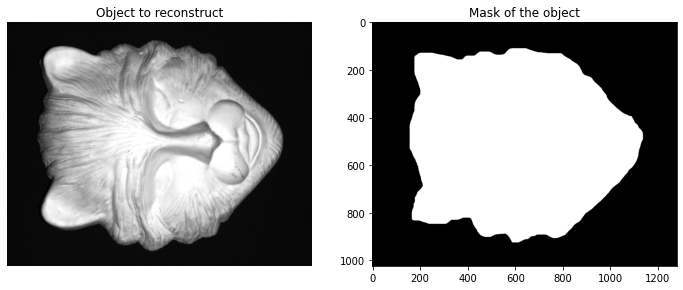

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].imshow(im, cmap='gray'), ax[0].axis('off'), ax[0].set_title('Object to reconstruct')
ax[1].imshow(mask, cmap='gray'), ax[1].set_title('Mask of the object')
plt.show()

## Aboluste phase maps estimation

We have a list of filename images in `imlist`. In that list we have fringe images and graycoding patterns

In [ ]:
imlist_ps = imlist[:2*N] # List of images for phase shifting
imlist_gc = imlist[2*N:-1] # List of images for for graycoding

When using graycoding, we different binary patterns for $x$ and $y$ projection direction. This amout can be estimated based on the projector image dimension (which is $1280\times800$)

In [ ]:
# Number of vertical and horizontal graycoding patterns
nv = 2*int(np.ceil(np.log2(1280/p)))
nh = 2*int(np.ceil(np.log2(800/p)))

For absolute phase estimation we use the phase-shifting + graycoding temporal phase unwrapping mehtod. The function for unwrapping is available on the [repository]()https://github.com/opi-lab/stsiva-workshop/blob/main/modules/ps_gc.py) of the workshop. For this example, we will just import the needed function by dowloading this file.

In [ ]:
!wget https://raw.githubusercontent.com/opi-lab/stsiva-workshop/main/modules/ps_gc.py

--2021-09-17 18:50:20--  https://raw.githubusercontent.com/opi-lab/stsiva-workshop/main/modules/ps_gc.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495 (1.5K) [text/plain]
Saving to: ‘ps_gc.py.4’

ps_gc.py.4          100%[===================>]   1.46K  --.-KB/s    in 0s      

2021-09-17 18:50:20 (21.2 MB/s) - ‘ps_gc.py.4’ saved [1495/1495]



Vertical absolute phase map estimation $\Phi_x$.

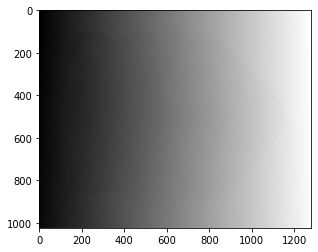

In [ ]:
import ps_gc

# Estimate absolute phase in x using phase shifting + graycoding method
Phix = ps_gc.phaseGraycodingUnwrap(imlist_ps[:N], imlist_gc[:nv], p, N)

plt.figure()
plt.imshow(Phix, cmap='gray')
plt.show()

Horizontal absolute phase map estimation $\Phi_y$.

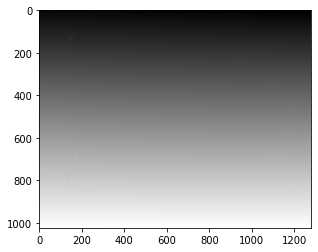

In [ ]:
# Estimate absolute phase in y using phase shifting + graycoding method
Phiy = ps_gc.phaseGraycodingUnwrap(imlist_ps[N:], imlist_gc[nv:nv+nh], p, N)

plt.figure()
plt.imshow(Phiy, cmap='gray')
plt.show()

## Camera projector correspondences

With the absolute phase maps $\Phi_x$ and $\Phi_y$ we can establish camera projector matches based on the following expression:

$$
x^p = \dfrac{p}{2\pi} \Phi_x(x^c, y^c) \enspace, \\
y^p = \dfrac{p}{2\pi} \Phi_y(x^c, y^c) \enspace,
$$

for a camera point $(x^c, y^c)$ we can estimate the $(x^p, y^p)$ corresponding projector point, where $p$ is the period or pitch of the fringes (stored in the variable `p`).

As a example, let's estimate the corresponding point in the projector for a camera point $(600, 600)$.

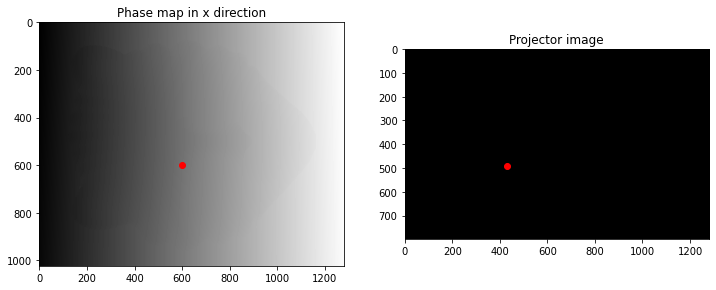

In [ ]:
# (x, y) camera coordinates
ptc1 = np.array([600, 600])

# Corresponding (x, y) projector coordinates
ptp1 = p/(2*np.pi)*np.array([Phix[ptc1[1],ptc1[0]], Phiy[ptc1[1],ptc1[0]]])

# Plot example
im_proj = np.zeros([800,1280], np.uint8)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].imshow(Phix, cmap='gray'), ax[0].set_title('Phase map in x direction')
ax[0].plot(ptc1[0], ptc1[1], 'ro')

ax[1].imshow(im_proj, cmap='gray'), ax[1].set_title('Projector image')
ax[1].plot(ptp1[0], ptp1[1], 'ro')
plt.show()

Estimate the 3D coordinates of that point. This can be calculated with the OpenCV's `triangulatePoints` function.

In [ ]:
# 3D point
p3d1 = cv2.triangulatePoints(P1, P2, ptc1.astype(np.float), ptp1)
p3d1 = p3d1[:3]/p3d1[-1]
print(f'Final 3D point\n{p3d1}')

Final 3D point
[[ -3.15213969]
 [ 14.28509498]
 [610.74882274]]


We can plot this point in 3D. To have a notion of the position of the point relative to the camera and the projector, we can plot the center o these devices. In the calibration procedure, typically the camera is set as the global origin (0, 0, 0). We need to estimate the projector center, and we can do that with the rotation and translation vector between both devices

In [ ]:
Oc = np.array([0,0,0]) # Camera center
Op = -R.T @ t # Projector center
print(f'Projector center location\n{Op}')

Projector center location
[[85.94434956]
 [14.40280401]
 [14.8724413 ]]


We can now plot the devices centers and the reconstructed point in 3D. We will use as red point the camera center, and as the green point the projector center. In black the reconstructed point from the object.

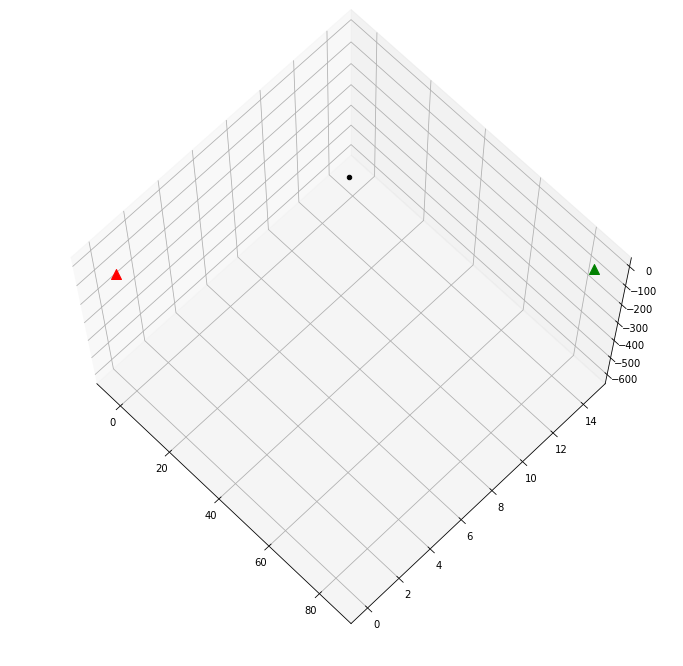

In [ ]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.view_init(70, -45) # Point of view for a better visualization

ax.scatter(Oc[0], Oc[1], Oc[2], c='r', s=100, marker='^')
ax.scatter(Op[0,0], Op[1,0], -Op[2,0], c='g', s=100, marker='^')
ax.scatter(p3d1[0,0], p3d1[1,0], -p3d1[2,0], c='k')

plt.show()

### TODO

Reconstruct an additional 3D point and plot it in 3D. For that, you need to find a point into the mask to establish the camera coordinates. W recommend to store that point in a `ptc2` variable. Then, you need to estimate the correspondence in the projector `ptp2`. Finally you can triangulate the point to estimate `p3d2`. For the 3D plot, use the above code and add an additional line for `p3d2`.

## Entire object reconstuction

with the estimated absolute phase maps, we can convert the phase values to pixel values on the projector image. For that, we first need the camera coordinates. We just consider the points into the mask.

In [ ]:
# Camera 2D coordinates
yc, xc = np.where(mask)

Noew, we need to estimate the projector coordinates, remember
$$
x^p = \dfrac{p}{2\pi} \Phi_x(x^c, y^c) \enspace, \quad y^p = \dfrac{p}{2\pi} \Phi_y(x^c, y^c) \enspace,
$$

### TODO

Estimate the `xp` and `yp` coordinates. Note: the phase map should be indexed as `Phase[yc, xc]` because we the phase maps are matrices where the first index correspond to rows and the second to columns.

In [ ]:
# Projector 2D coordinates

For 3D reconstruction is important to compensate for lens distortion both camera and projector points to obtain low reconstruction errors.

In [ ]:
# Converting the coordinates to (n, 1, 2) arrays
ptsc = np.c_[xc,yc].reshape(-1,1,2).astype(np.float)
ptsp = np.c_[xp,yp].reshape(-1,1,2)

# Points undistortion with OpenCV
ptscu = cv2.undistortPoints(ptsc, K1, dist1, None, None, K1)
ptspu = cv2.undistortPoints(ptsp, K2, dist2, None, None, K2)

## 3D reconstruction

Once matches are established and the distortion is removed for the correspondences, we can solve the structure of the object. We will use stereo triangulation with the OpenCV's function `triangulatePoints`.

In [ ]:
# Triangulate (DLT method)
X = cv2.triangulatePoints(P1, P2, ptscu, ptspu)
X = X[:3]/X[-1] # From homogeneous to Euclidean

For 3D visualization we need first the colors of each 3D point, which correspond to the grayscale values of each camera pixel.

In [ ]:
C = im[yc,xc]

Using `matplotlib` for 3D visualization:

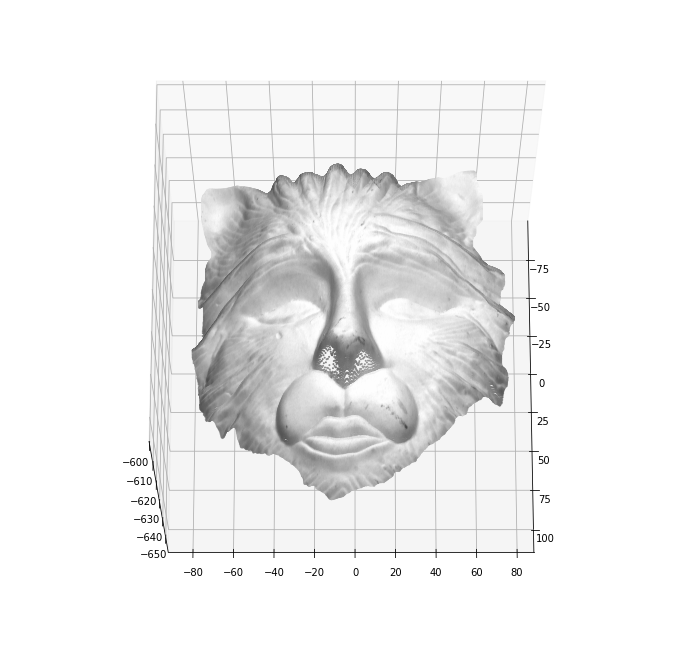

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.view_init(70, 0) # Point of view for a better visualization
ax.scatter(X[0], X[1], -X[2], c=np.stack(3*[C], 1)/255.0, s=1)
plt.show()